In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

git rm --cached "Assignment_2/Robotic Arm/IMU_2Hz.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_10Hz.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_20Hz_freq_drop_2.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_20Hz_freq_drop.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_Acc_Gyro_20Hz.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_earthquake.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_extra_weigth.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_hitting_arm.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_hitting_platform.csv"
git rm --cached "Assignment_2/Robotic Arm/IMU_magnet.csv"
git rm --cached "Assignment_2/Robotic Arm/nicla.csv"
git rm --cached "Assignment_2/Robotic Arm/quaternions_20Hz.csv"
git rm --cached "Assignment_2/Robotic Arm/quaternions_no_idle.csv"

# Imports and Functions

In [2]:
import seaborn as sns
import pandas as pd
from scipy.stats import skew, kurtosis

def get_data_frame(filename):
    CSV_FOLDER_NAME = "Robotic Arm"
    csv_filepath = os.path.join(CSV_FOLDER_NAME, filename)
    return pd.read_csv(csv_filepath)

def plot_corr_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(25, 20))
    sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show() 

def add_time_column(df):
    df['time'] = pd.to_datetime(df['time'], unit='ns')
    df.set_index('time', inplace=True)
    return df

def extract_rolling_features(df):
    sensor_cols = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

    # Use a rolling window of 1 second and extraxt key features
    features_df = df[sensor_cols].rolling(window='1S').agg(['mean', 'std', 'max', 'min'])

    # Flatten MultiIndex
    features_df.columns = ['_'.join(col).strip() for col in features_df.columns]
    
    # Remove nan (to be sure)
    features_df = features_df.dropna().reset_index(drop=True)
    
    return features_df

def resample_to_10Hz(df):
    # Behold kun numeriske kolonner for resampling
    df_numeric = df.select_dtypes(include=[np.number])

    # Resample til target frequency (10Hz = 100ms)
    df_resampled = df_numeric.resample("100ms").mean().dropna()
    return df_resampled

# Explore the Data

In [3]:
raw_data = get_data_frame("IMU_10Hz.csv")
raw_data.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,IMU8,1686062828391000000,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
1,IMU8,1686062828537000000,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2,IMU8,1686062828585000000,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
3,IMU8,1686062828682000000,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
4,IMU8,1686062828780000000,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874937 entries, 0 to 874936
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    874937 non-null  object 
 1   time    874937 non-null  int64  
 2   accX    874937 non-null  float64
 3   accY    874937 non-null  float64
 4   accZ    874937 non-null  float64
 5   gyroX   874937 non-null  float64
 6   gyroY   874937 non-null  float64
 7   gyroZ   874937 non-null  float64
 8   magX    874937 non-null  float64
 9   magY    874937 non-null  float64
 10  magZ    874937 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 73.4+ MB


In [5]:
raw_data = add_time_column(raw_data)
raw_data.head()

,name,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
time,,,,,,,,,,
2023-06-06 14:47:08.391,IMU8,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
2023-06-06 14:47:08.537,IMU8,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2023-06-06 14:47:08.585,IMU8,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
2023-06-06 14:47:08.682,IMU8,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
2023-06-06 14:47:08.780,IMU8,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [6]:
# Look for missing data
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


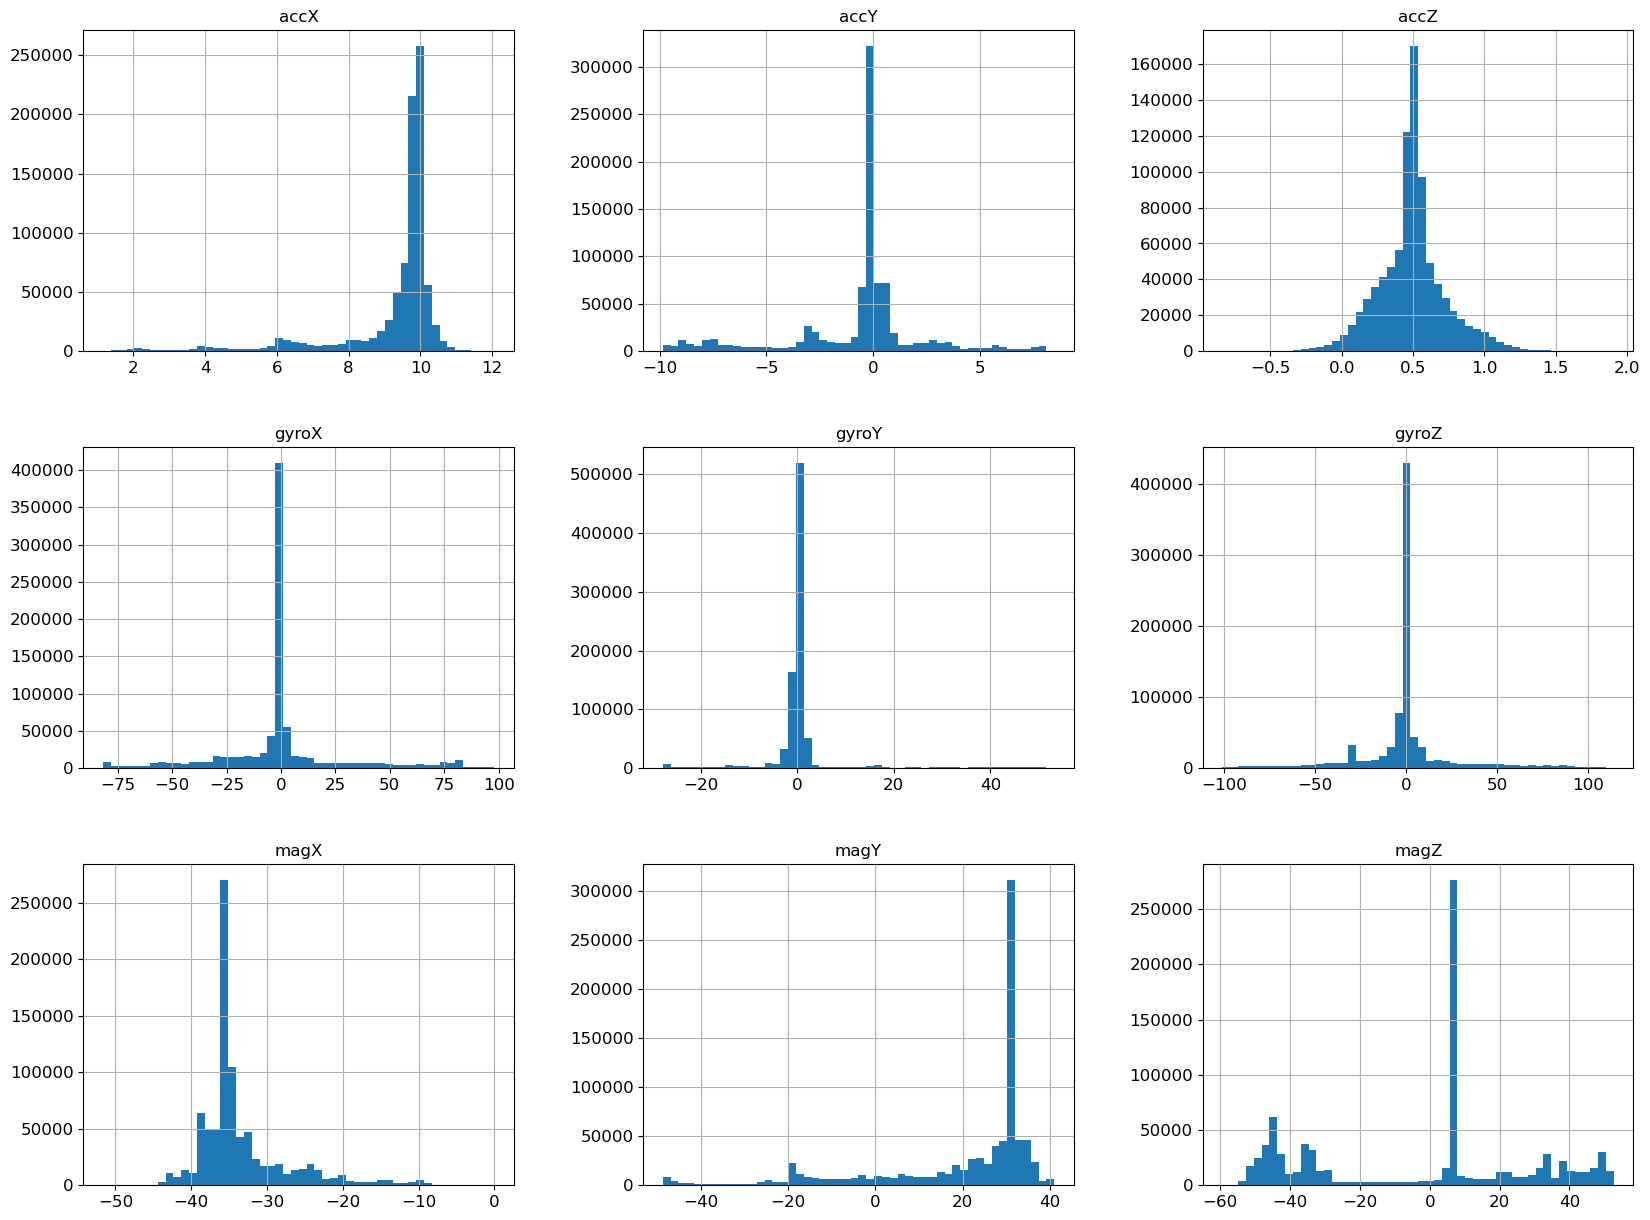

In [7]:
raw_data.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# Split normal data into test and train using a ratio to improve speed
ratio_train = 0.5

split_idx = int(len(raw_data) * ratio_train)

# Split the data
train_data = raw_data[:split_idx]
test_data = raw_data[split_idx:] 

print(f'Length train: {len(train_data)}')
print(f'Length test: {len(test_data)}')

Length train: 437468
Length test: 437469


In [9]:
# Resample to 10Hz
df_resampled = resample_to_10Hz(train_data)

# Extract rolling features
X_normal = extract_rolling_features(df_resampled)

X_normal.head()

,accX_mean,accX_std,accX_max,accX_min,accY_mean,accY_std,accY_max,accY_min,accZ_mean,accZ_std,...,magX_max,magX_min,magY_mean,magY_std,magY_max,magY_min,magZ_mean,magZ_std,magZ_max,magZ_min
0,9.786898,0.019469,9.800664,9.773131,0.244807,0.017776,0.257377,0.232238,0.478242,0.017776,...,0.0,-48.42,-3.730000,5.275017,0.0,-7.46,-6.615385,9.355567,0.0,-13.230769
1,9.781511,0.016631,9.800664,9.770737,0.237425,0.017930,0.257377,0.222661,0.467268,0.022787,...,0.0,-48.52,-4.926667,4.267193,0.0,-7.46,-8.897436,7.706269,0.0,-13.461538
2,9.784204,0.014608,9.800664,9.770737,0.233734,0.016396,0.257377,0.222661,0.466570,0.018658,...,0.0,-48.52,-5.515000,3.677477,0.0,-7.46,-10.096154,6.733406,0.0,-13.692307
3,9.784863,0.012737,9.800664,9.770737,0.235829,0.014952,0.257377,0.222661,0.473334,0.022132,...,0.0,-48.52,-5.924000,3.313500,0.0,-7.56,-10.876923,6.087041,0.0,-14.000000
4,9.790489,0.017880,9.818621,9.770737,0.238822,0.015251,0.257377,0.222661,0.473852,0.019836,...,0.0,-48.52,-6.190000,3.034462,0.0,-7.56,-11.307692,5.545722,0.0,-14.000000


# Scaling the Data

In [10]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# Train Gaussian Mixture

In [11]:
from sklearn.mixture import GaussianMixture

# Tune number of components
n_components = 3  

# Train the model on normal data
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=21)
gmm.fit(X_normal_scaled)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\hakon\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\hakon\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\hakon\anaconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8f in position 25: invalid start byte
c:\Users\hakon\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hakon\anaconda3\Lib\site-packa

GaussianMixture(n_components=3, random_state=21)

Define threshold

In [12]:
# Calculate threshold
log_likelihood_train = gmm.score_samples(X_normal_scaled)
threshold_train = np.percentile(log_likelihood_train, 5) # 5%

# Testing

In [13]:
def print_anomaly_fraction(filename, threshold, gmm, scaler):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    # Resample to 10Hz to keep concistancy
    df_resampled = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df_resampled)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Return the fraction of anomalties
    return anomalies.mean()

In [14]:
print_anomaly_fraction("IMU_10Hz.csv", threshold_train, gmm, scaler)

0.04950094999879747

In [15]:
print_anomaly_fraction("IMU_earthquake.csv", threshold_train, gmm, scaler)

0.978403929928631

In [16]:
print_anomaly_fraction("IMU_20Hz_freq_drop.csv", threshold_train, gmm, scaler)

0.15628030020510908

In [17]:
print_anomaly_fraction("IMU_20Hz_freq_drop_2.csv", threshold_train, gmm, scaler)

0.14562031275312323

In [18]:
print_anomaly_fraction("IMU_hitting_platform.csv", threshold_train, gmm, scaler)

0.47015825704350295

In [19]:
print_anomaly_fraction("IMU_extra_weigth.csv", threshold_train, gmm, scaler)

0.3871664050235479

# Test Anomaly Detection

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_anomalies_histogram(filename, threshold, gmm, scaler, x_start=-500, x_end=50, resample_10Hz=True):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10Hz to keep consistency
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(log_likelihood, bins=100, color='gray', alpha=0.7, label="Log-Likelihood", edgecolor='black', density=True)

    # KDE (Kernel Density Estimate) for the distribution
    kde = gaussian_kde(log_likelihood, bw_method='silverman')
    x_range = np.linspace(min(log_likelihood), max(log_likelihood), 1000)
    kde_values = kde(x_range)

    # Shaded region under the KDE curve
    plt.fill_between(x_range, kde_values, color='blue', alpha=0.3, label="KDE (Density)")

    # Add a vertical line for anomaly threshold
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")

    # Add labels and title
    plt.xlabel('Log-Likelihood')
    plt.ylabel('Density')
    plt.title('Histogram of Log-Likelihood with Anomalies and KDE Distribution')
    plt.legend()

    plt.xlim(x_start, x_end)

    # Show plot
    plt.show()

    # Return the fraction of anomalies
    return anomalies.mean()


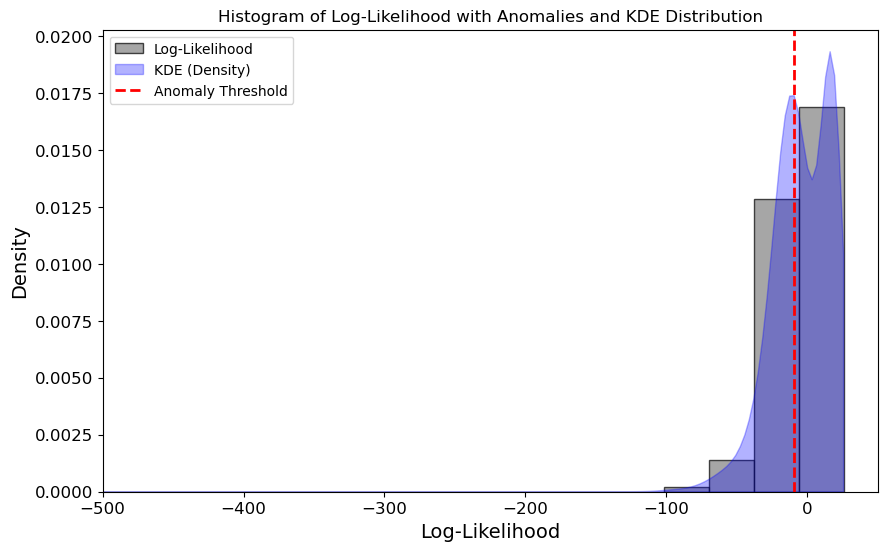

0.3871664050235479

In [21]:
plot_anomalies_histogram("IMU_extra_weigth.csv", threshold_train, gmm, scaler)

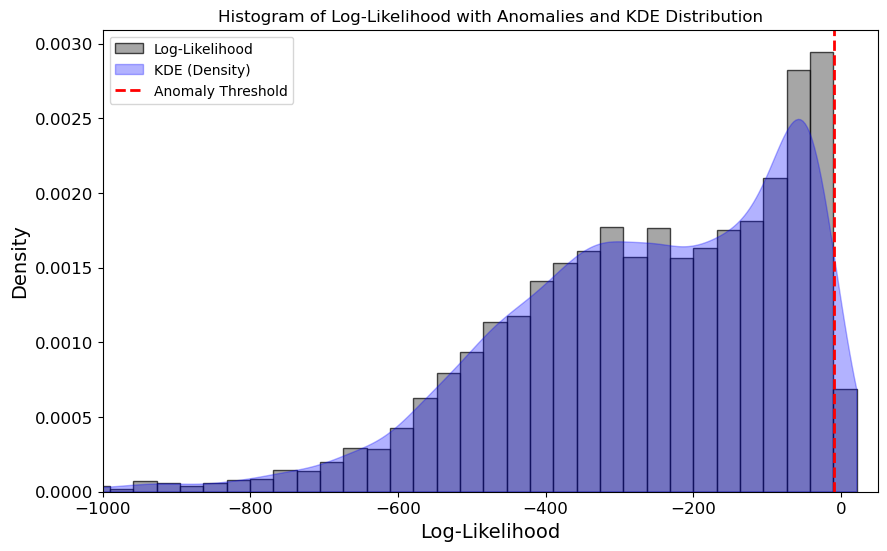

0.978403929928631

In [22]:
plot_anomalies_histogram("IMU_earthquake.csv", threshold_train, gmm, scaler, x_start=-1000)

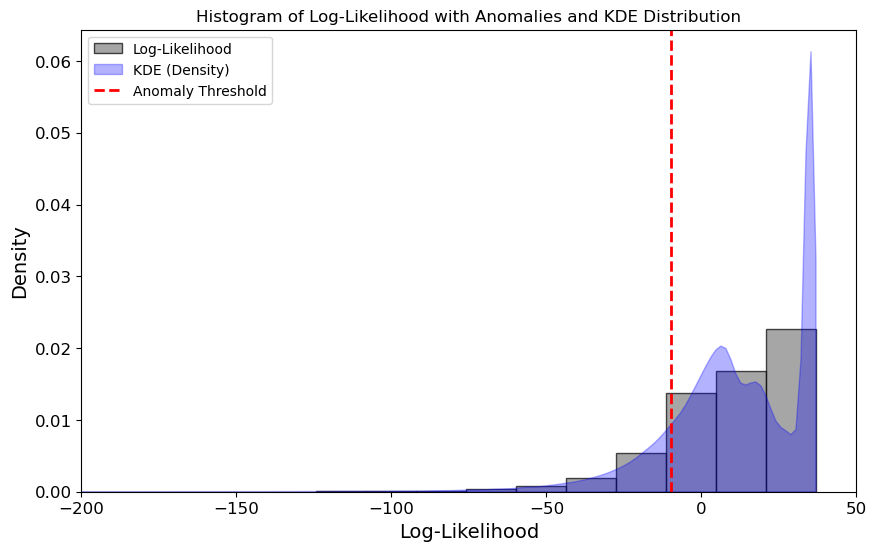

0.15628030020510908

In [23]:
plot_anomalies_histogram("IMU_20Hz_freq_drop.csv", threshold_train, gmm, scaler, x_start=-200)

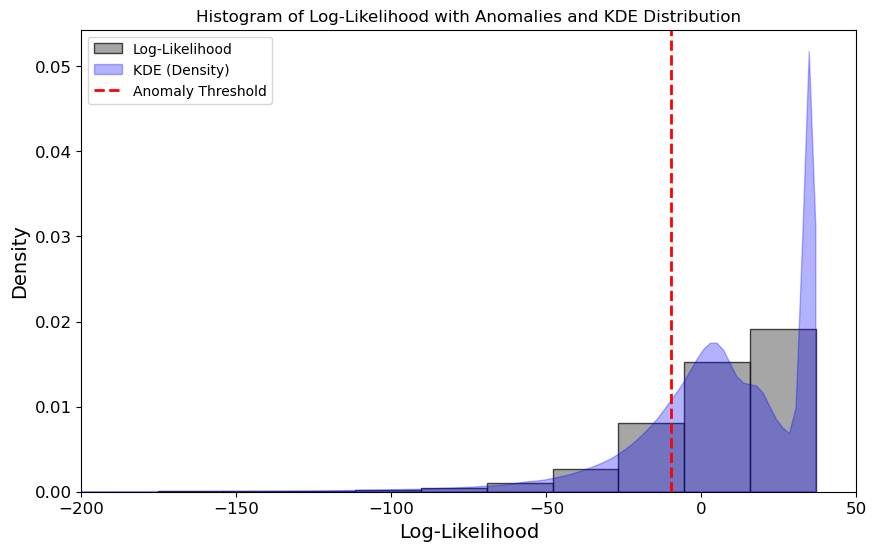

0.22020740542663514

In [24]:
plot_anomalies_histogram("IMU_20Hz_freq_drop.csv", threshold_train, gmm, scaler, x_start=-200, resample_10Hz=False)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_log_likelihood_timeseries(filename, threshold, gmm, scaler, resample_10Hz=True):
    # Hent data fra CSV
    df = get_data_frame(filename)

    # Legg til pandas tid
    df = add_time_column(df)

    if resample_10Hz:
        # Resample til 10Hz for konsistens
        df = resample_to_10Hz(df)

    # Ekstraher rolling features
    X_data = extract_rolling_features(df)

    # Skaler data
    X_data_scaled = scaler.transform(X_data)

    # Beregn log-likelihood og anomalier
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Hent tidsverdier
    time_values = df.index  

    # Definer interaktive widgets
    start_slider = widgets.IntSlider(value=0, min=0, max=len(time_values)-100, step=10, description='Start:')
    window_slider = widgets.IntSlider(value=500, min=100, max=5000, step=100, description='Window:')

    def update_plot(start, window):
        # Begrens visningsområdet
        end = min(start + window, len(time_values))

        # Rydd opp og plott på nytt
        plt.figure(figsize=(12, 6))
        plt.plot(time_values[start:end], log_likelihood[start:end], label="Log-Likelihood", color="blue")
        plt.scatter(time_values[start:end][anomalies[start:end]], 
                    log_likelihood[start:end][anomalies[start:end]], 
                    color='m', label="Anomalier", zorder=3, s=5)
        plt.axhline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")

        plt.xlabel("Time")
        plt.ylabel("Log-Likelihood")
        plt.title("Log-Likelihood Timeseries")
        plt.legend()
        plt.grid()
        plt.show()

    # Koble widgets til plottet
    interactive_plot = widgets.interactive(update_plot, start=start_slider, window=window_slider)
    display(interactive_plot)

    # Returner fraksjon av anomalier
    return anomalies.mean()


In [26]:
plot_log_likelihood_timeseries("IMU_extra_weigth.csv", threshold_train, gmm, scaler)


interactive(children=(IntSlider(value=0, description='Start:', max=10093, step=10), IntSlider(value=500, descr…

0.3871664050235479